Using device: cuda


Training Episodes:   0%|          | 0/20000 [00:00<?, ?it/s]

Episode 0, Total Reward: -2915.920686214405, Path Length: 300
Episode 100, Total Reward: -314.65020943618094, Path Length: 300
Episode 200, Total Reward: -347.32585757183244, Path Length: 300
Episode 300, Total Reward: -381.4731746527122, Path Length: 300
Episode 400, Total Reward: -362.1262473601977, Path Length: 300
Episode 500, Total Reward: -296.7558886373548, Path Length: 300
Episode 600, Total Reward: -353.0383470970527, Path Length: 300
Episode 700, Total Reward: -322.05050510305523, Path Length: 300
Episode 800, Total Reward: -401.8671105806634, Path Length: 300
Episode 900, Total Reward: -337.5744671790385, Path Length: 300
Episode 1000, Total Reward: -354.4851686847921, Path Length: 300
Episode 1100, Total Reward: -332.53673157446667, Path Length: 300
Episode 1200, Total Reward: -368.7558886373548, Path Length: 300
Episode 1300, Total Reward: -404.58781674764646, Path Length: 300
Episode 1400, Total Reward: -329.8388872919299, Path Length: 300
Episode 1500, Total Reward: -319

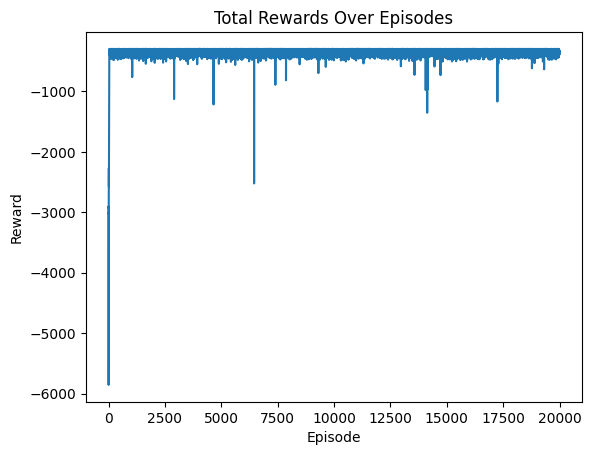

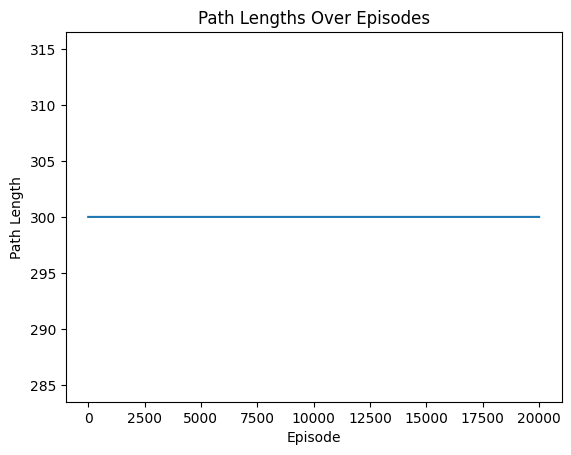

In [1]:
import numpy as np
from math import atan2, degrees, radians, cos, sin
from datetime import datetime, timedelta
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 경험 저장을 위한 named tuple 정의
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # 상태 가치 스트림
        self.value_stream = nn.Linear(64, 1)
        # 액션 이점 스트림
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        
        # Q 값 계산: V(s) + (A(s,a) - mean(A(s)))
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# 항해 환경 클래스 정의 (변경 없음)
class NavigationEnv:
    def __init__(self):
        # 그리드 맵 로드
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape
        
        # 경도/위도 범위
        self.lat_min, self.lat_max = 30, 38
        self.lon_min, self.lon_max = 120, 127
        
        # 시작점과 종료점 설정
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        
        # 시간 관리
        self.step_time_minutes = 12
        self.max_steps = 300
        self.cumulative_time = 0
        self.step_count = 0
        
        # 조류 및 풍향/풍속 데이터 경로
        self.tidal_data_dir = r"C:\baramproject\tidal_database"
        self.wind_data_dir = r"C:\baramproject\wind_database_2"
        
        # 액션 공간 정의 (상대 각도: 종료점 방향 기준 8방향)
        self.action_space = np.array([0, 45, 90, 135, 180, -135, -90, -45])  # 상대 각도 (도 단위)
        
        # 그리드 이동 방향 매핑 (상, 우상, 우, 우하, 하, 좌하, 좌, 좌상)
        self.grid_directions = [
            (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)
        ]
        
        # 연비 효율 관련 계수
        self.k_c = 0.1  # 조류 영향 계수
        self.k_w = 0.005  # 풍속 영향 계수
        
        # 경로 저장용 리스트
        self.path = []
        
        # 환경 초기화
        self.reset()

    def latlon_to_grid(self, lat, lon):
        """위도/경도를 그리드 좌표로 변환"""
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self, start_time=None):
        start_date = datetime(2018, 1, 1, 0, 0)
        end_date = datetime(2018, 12, 29, 0, 0)  # 12월 29일로 변경하여 여유를 둠
        if start_time is None:
            time_delta = (end_date - start_date).total_seconds()
            random_seconds = np.random.randint(0, int(time_delta / 60 / 30) + 1) * 30 * 60
            start_time = start_date + timedelta(seconds=random_seconds)
        
        self.current_pos = self.start_pos
        self.visit_count = {}
        self.prev_action = None
        self.current_time = start_time
        self.cumulative_time = 0
        self.load_tidal_data()
        self.map_tidal_to_grid()
        self.load_wind_data()
        self.map_wind_to_grid()
        self.prev_distance = self.get_distance_to_end()
        self.step_count = 0
        self.path = [self.current_pos]
        return self._get_state()

    def get_relative_position_and_angle(self):
        """종료점을 기준으로 한 상대 좌표와 각도 계산"""
        rel_pos = np.array(self.end_pos) - np.array(self.current_pos)
        distance = np.linalg.norm(rel_pos)
        end_angle = degrees(atan2(rel_pos[1], rel_pos[0])) % 360
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        """종료점까지의 거리 계산"""
        rel_pos = np.array(self.end_pos) - np.array(self.current_pos)
        return np.linalg.norm(rel_pos)

    def angle_to_grid_direction(self, abs_action_angle):
        """절대 각도를 그리드 이동 방향으로 매핑"""
        grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
        angle_diff = np.abs(grid_angles - abs_action_angle)
        closest_idx = np.argmin(angle_diff)
        return self.grid_directions[closest_idx]

    def load_data(self, data_dir, filename_prefix, time_str):
        data_file = os.path.join(data_dir, f"{filename_prefix}{time_str}.json")
        if not os.path.exists(data_file):
            print(f"Warning: Data file {data_file} not found. Episode will be terminated.")
            return None
        
        with open(data_file, 'r') as f:
            data = json.load(f)
        return data["result"]["data"]

    def map_data_to_grid(self, data, dir_key, speed_key):
        """공통 데이터 매핑 함수"""
        grid_dir = np.zeros((self.n_rows, self.n_cols))
        grid_speed = np.zeros((self.n_rows, self.n_cols))
        grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)
        
        if data is None:
            return grid_dir, grid_speed, grid_valid
        
        positions = [(float(item["pre_lat"]), float(item["pre_lon"])) for item in data]
        directions = [float(item[dir_key]) for item in data]
        speeds = [float(item[speed_key]) for item in data]
        
        for pos, dir, speed in zip(positions, directions, speeds):
            lat, lon = pos
            row, col = self.latlon_to_grid(lat, lon)
            if 0 <= row < self.n_rows and 0 <= col < self.n_cols:
                grid_dir[row, col] = dir
                grid_speed[row, col] = speed
                grid_valid[row, col] = True
        
        return grid_dir, grid_speed, grid_valid

    def load_tidal_data(self):
        """조류 데이터 로드"""
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        tidal_data = self.load_data(self.tidal_data_dir, "tidal_", time_str)
        if tidal_data is not None:
            self.tidal_data = tidal_data
        else:
            self.tidal_data = None  # 데이터가 없으면 None으로 설정

    def map_tidal_to_grid(self):
        """조류 데이터를 그리드에 매핑"""
        if self.tidal_data is not None:
            self.tidal_grid_dir, self.tidal_grid_speed, self.tidal_grid_valid = self.map_data_to_grid(
                self.tidal_data, "current_dir", "current_speed"
            )
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols))
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols))
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)

    def load_wind_data(self):
        """풍향/풍속 데이터 로드"""
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        wind_data = self.load_data(self.wind_data_dir, "wind_", time_str)
        if wind_data is not None:
            self.wind_data = wind_data
        else:
            self.wind_data = None  # 데이터가 없으면 None으로 설정

    def map_wind_to_grid(self):
        """풍향/풍속 데이터를 그리드에 매핑"""
        if self.wind_data is not None:
            self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid = self.map_data_to_grid(
                self.wind_data, "wind_dir", "wind_speed"
            )
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols))
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols))
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)

    def calculate_fuel_consumption(self, abs_action_angle, position):
        """연료 소비 계산"""
        row, col = position
        
        tidal_dir, tidal_speed = 0, 0
        if 0 <= row < self.n_rows and 0 <= col < self.n_cols and self.tidal_grid_valid[row, col]:
            tidal_dir = self.tidal_grid_dir[row, col]
            tidal_speed = self.tidal_grid_speed[row, col]
        
        wind_dir, wind_speed = 0, 0
        if 0 <= row < self.n_rows and 0 <= col < self.n_cols and self.wind_grid_valid[row, col]:
            wind_dir = self.wind_grid_dir[row, col]
            wind_speed = self.wind_grid_speed[row, col]
        
        tidal_dir_rad = (90 - tidal_dir) * np.pi / 180
        wind_dir_rad = (90 - wind_dir) * np.pi / 180
        action_angle_rad = (90 - abs_action_angle) * np.pi / 180
        
        theta_c = action_angle_rad - tidal_dir_rad
        theta_w = action_angle_rad - wind_dir_rad

        V_s = 6.69
        
        f_0 = 1

        tidal_relative_speed = V_s - tidal_speed * np.cos(theta_c)
        if tidal_relative_speed > 0:
            tidal_effect = f_0 * (tidal_relative_speed / V_s) ** 3
        else:
            tidal_effect = f_0

        wind_effect = self.k_w * wind_speed ** 2 * np.cos(theta_w)
        
        total_fuel = wind_effect + tidal_effect
        
        return total_fuel

    def step(self, action):
        """환경 스텝 실행"""
        # 스텝 수 증가
        self.step_count += 1
    
        # 상대 위치 및 각도 계산
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360
        
        # 턴 페널티 계산 (이전 방향이 있을 경우)
        turn_penalty = 0
        if hasattr(self, 'previous_direction') and self.previous_direction is not None:
            angle_diff = min((abs_action_angle - self.previous_direction) % 360, 
                             (self.previous_direction - abs_action_angle) % 360)
            turn_penalty = angle_diff * 0.1
        
        # 그리드 이동 방향 계산
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        # 연료 소비 계산
        current_fuel = self.calculate_fuel_consumption(abs_action_angle, self.current_pos)
        next_fuel = self.calculate_fuel_consumption(abs_action_angle, new_pos)
        fuel_reduction = current_fuel - next_fuel
        
        # 새 위치가 유효한지 확인하고 이동
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
        
        # 이전 방향 업데이트
        self.previous_direction = abs_action_angle
        
        # 이전 액션 업데이트
        self.prev_action = action
        
        # 시간 업데이트
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            next_time = self.current_time + timedelta(minutes=30)
            end_date = datetime(2018, 12, 31, 23, 30)
            if next_time <= end_date:
                self.current_time = next_time
                self.load_tidal_data()
                self.map_tidal_to_grid()
                self.load_wind_data()
                self.map_wind_to_grid()
            else:
                print("Warning: Time exceeds 2018 range. Keeping previous data.")
            self.cumulative_time -= 30
        
        # 상태, 보상, 종료 여부 계산
        state = self._get_state()
        current_distance = self.get_distance_to_end()
        distance_reward = (self.prev_distance - current_distance) * 2.0
        self.prev_distance = current_distance
        
        goal_reward = 100 if tuple(self.current_pos) == self.end_pos else 0
        reward = -current_fuel + fuel_reduction * 1.0 + distance_reward - turn_penalty + goal_reward
        
        # 종료 조건: 목표 도달 또는 스텝 수 300 초과
        done = tuple(self.current_pos) == self.end_pos or self.step_count >= self.max_steps
        
        return state, reward, done, {}

    def _get_state(self):
        row, col = self.current_pos
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        
        tidal_dir, tidal_speed = 0, 0
        if hasattr(self, 'tidal_grid_valid') and self.tidal_grid_valid[row, col]:
            tidal_dir = self.tidal_grid_dir[row, col]
            tidal_speed = self.tidal_grid_speed[row, col]
        
        wind_dir, wind_speed = 0, 0
        if hasattr(self, 'wind_grid_valid') and self.wind_grid_valid[row, col]:
            wind_dir = self.wind_grid_dir[row, col]
            wind_speed = self.wind_grid_speed[row, col]
        
        return np.array([rel_pos[0], rel_pos[1], distance, tidal_dir, tidal_speed, wind_dir, wind_speed])

# DQN 에이전트 클래스 정의 (Multi-Step Learning 통합)
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.lr = 0.0001
        self.gamma = 0.99
        self.batch_size = 64
        self.buffer_size = 100000
        self.target_update = 1000
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 10000
        self.n_steps = 3  # Multi-Step Learning의 스텝 수
        
        self.alpha = 0.6  # PER의 alpha (미사용)
        self.beta_start = 0.4  # PER의 beta (미사용)
        self.beta_end = 1.0
        
        # 모델을 GPU로 이동
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        self.memory = deque(maxlen=self.buffer_size)  # 경험 버퍼
        self.step_count = 0
        
    def select_action(self, state, epsilon):
        """액션 선택"""
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        """경험 저장"""
        experience = Experience(state, action, reward, next_state, done)
        self.memory.append(experience)  # Multi-Step을 위해 단순히 경험만 저장 (우선순위 제외)

    def sample_batch(self):
        """Multi-Step 샘플링"""
        if len(self.memory) < self.batch_size + self.n_steps:
            return None
        
        batch = []
        # 무작위 인덱스에서 n-step 연속 경험 추출
        indices = random.sample(range(len(self.memory) - self.n_steps), self.batch_size)
        
        for idx in indices:
            n_step_experiences = []
            for i in range(self.n_steps):
                exp = self.memory[idx + i]
                if exp.done and i > 0:  # 에피소드 경계 체크
                    break
                n_step_experiences.append(exp)
            batch.append(n_step_experiences)
        
        return batch

    def compute_loss(self, batch, beta):
        """Multi-Step 손실 계산"""
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        # n-step 경험 처리
        for n_step_experiences in batch:
            if len(n_step_experiences) < self.n_steps:
                continue  # 충분한 스텝이 없으면 건너뜀
            state = n_step_experiences[0].state           # 시작 상태
            action = n_step_experiences[0].action         # 시작 액션
            # n-step 누적 보상 계산
            reward = sum([self.gamma ** i * exp.reward for i, exp in enumerate(n_step_experiences)])
            next_state = n_step_experiences[-1].next_state  # n번째 다음 상태
            done = n_step_experiences[-1].done             # 종료 여부
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
        if not states:
            return None  # 유효한 배치가 없으면 None 반환
        
        # 텐서로 변환 및 GPU로 이동
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # 현재 Q 값 계산
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # n-step 타겟 계산
        with torch.no_grad():
            next_actions = self.policy_net(next_states).max(1)[1].unsqueeze(1)
            target_next_q_values = self.target_net(next_states).gather(1, next_actions)
            targets = rewards + (1 - dones) * (self.gamma ** self.n_steps) * target_next_q_values.squeeze()
        
        # 손실 계산 (MSE)
        loss = nn.MSELoss()(q_values.squeeze(), targets)
        return loss

    def update(self):
        """모델 업데이트"""
        if len(self.memory) < self.batch_size + self.n_steps:
            return
        
        beta = self.beta_start + (self.beta_end - self.beta_start) * min(1.0, self.step_count / 50000)
        batch = self.sample_batch()
        if batch is None:
            return
        
        loss = self.compute_loss(batch, beta)
        if loss is None:
            return
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# 학습 루프 정의 (변경 없음)
def train_dqn(env, agent, max_episodes=20000):
    rewards = []
    path_lengths = []
    epsilon = agent.epsilon_start
    
    image_dir = r"C:\baramproject\trained_model\sibal19\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\sibal19\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    for episode in tqdm(range(max_episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        path_length = 0
        done = False
        debug_data = []
        
        while not done:
            epsilon = max(agent.epsilon_end, epsilon - (agent.epsilon_start - agent.epsilon_end) / agent.epsilon_decay)
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            debug_data.append({
                "step": path_length,
                "state": state.tolist(),
                "action": action,
                "reward": reward,
                "next_state": next_state.tolist(),
                "q_values": q_values.tolist(),
                "epsilon": epsilon
            })
            
            agent.store_experience(state, action, reward, next_state, done)
            agent.update()
            
            state = next_state
            total_reward += reward
            path_length += 1
        
        rewards.append(total_reward)
        path_lengths.append(path_length)
        
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Path Length: {path_length}")
            
            plt.figure(figsize=(10, 8))
            plt.imshow(env.grid, cmap='gray')
            path_array = np.array(env.path)
            plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
            plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
            plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
            plt.legend()
            plt.title(f"Episode {episode} Path")
            plt.savefig(os.path.join(image_dir, f"episode_{episode}.png"))
            plt.close()
            
            with open(os.path.join(data_dir, f"episode_{episode}.json"), 'w') as f:
                json.dump(debug_data, f, indent=4)
        
        if episode % 1000 == 0 and episode > 0:
            plt.plot(rewards)
            plt.title("Total Rewards Over Episodes")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.savefig(os.path.join(image_dir, f"rewards_episode_{episode}.png"))
            plt.close()
    
    torch.save(agent.policy_net.state_dict(), r"C:\baramproject\trained_model\sibal19\navigation_model.pth")
    return rewards, path_lengths

# 메인 실행
if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 7
    action_dim = len(env.action_space)
    agent = DQNAgent(state_dim, action_dim)
    
    rewards, path_lengths = train_dqn(env, agent)
    
    plt.plot(rewards)
    plt.title("Total Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    
    plt.plot(path_lengths)
    plt.title("Path Lengths Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Path Length")
    plt.show()